## T019 Molecular dynamics simulation
* https://projects.volkamerlab.org/teachopencadd/talktorials/T019_md_simulation.html

### TOC
#### 1. Preparation of complex pbd
* Download PDB file
* Prepare the protein ligand complex
    * Protein preparation
    * Ligand preparation
    * Merge protein and ligand
#### 2. MD simulation
* MD simulation set up
    * Force field
    * System
* Perform the MD simulation
* Download results

### Some tips
* For simulations under periodic boundary conditions, it is recommended to use a simulation box large enough, so that the simulated macromolecule does not come into contact with neighboring images of itself.

### Advantage of MD simulation
* MD give valuable insights into the highly dynamic process of ligand binding to their target.
* ligands may induce conformational changes in the macromolecule that can best accommodate the small molecule.
    * binding sites that are not observed in static ligand-free structures, but can be discovered with MD simulations, are sometimes called cryptic binding sites.
    * The identification of such binding sites with MD simulation can kickstart new drug discovery campaigns.
* Later in the drug discovery process, MD simulations can also be used to estimate the quality of computationally identified small molecules before performing more costly and time-intensive in vitro tests. 


In [9]:
# Load libaries
import copy
from pathlib import Path

import requests
from IPython.display import display
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import mdtraj as md
import pdbfixer
import nglview as nv
import openmm as mm
import openmm.app as app
from openmm import unit
from openff.toolkit.topology import Molecule, Topology
from openmmforcefields.generators import GAFFTemplateGenerator

In [18]:
# create data directory if not exists
data_dir = Path("./data/EGPR_tutorial")
Path(data_dir).mkdir(parents=True, exist_ok=True)
result_dir = Path("./results/EGPR_tutorial")
Path(result_dir).mkdir(parents=True, exist_ok=True)

In [6]:
# Download the PDB file
pdbid = "3POZ" # EGFR kinase domain
ligand_name = "03P"
pdb_file = data_dir / f"{pdbid}.pdb"
pbd_url = f"https://files.rcsb.org/download/{pdbid}.pdb"
# !wget -O {pdb_file} {pbd_url} # you need to run this at first time
# after downloading the file, you need pdb_file path.

### Protein preparation
* A crucial part for successful simulation is a correct and complete system. Crystallographic structures retrieved from the Protein Data Bank often miss atoms, mainly hydrogens, and may contain non-standard residues. 
* In this talktorial, we will use the Python package PDBFixer to prepare the protein structure. However, co-crystallized ligands are not handled well by PDBFixer and will thus be prepared separately.

In [70]:
def prepare_protein(
    pdb_file, ignore_missing_residues=True, ignore_terminal_missing_residues=True, ph=7.0
):
    """
    Use pdbfixer to prepare the protein from a PDB file. Hetero atoms such as ligands are
    removed and non-standard residues replaced. Missing atoms to existing residues are added.
    Missing residues are ignored by default, but can be included.

    Parameters
    ----------
    pdb_file: pathlib.Path or str
        PDB file containing the system to simulate.
    ignore_missing_residues: bool, optional
        If missing residues should be ignored or built.
    ignore_terminal_missing_residues: bool, optional
        If missing residues at the beginning and the end of a chain should be ignored or built.
    ph: float, optional
        pH value used to determine protonation state of residues

    Returns
    -------
    fixer: pdbfixer.pdbfixer.PDBFixer
        Prepared protein system.
    """
    fixer = pdbfixer.PDBFixer(str(pdb_file))
    fixer.removeHeterogens()  # co-crystallized ligands are unknown to PDBFixer
    fixer.findMissingResidues()  # identify missing residues, needed for identification of missing atoms

    # if missing terminal residues shall be ignored, remove them from the dictionary
    if ignore_terminal_missing_residues:
        chains = list(fixer.topology.chains())
        keys = fixer.missingResidues.keys()
        for key in list(keys):
            chain = chains[key[0]]
            if key[1] == 0 or key[1] == len(list(chain.residues())):
                # remove terminal missing residues
                residue_name = fixer.missingResidues[key]
                print(f"Removing terminal missing residue {key} of {chain}, {residue_name}")
                del fixer.missingResidues[key]
            else:
                residue_name = fixer.missingResidues[key]
                print(f"Keeping missing residue {key} of {chain}, {residue_name}")

    # if all missing residues shall be ignored ignored, clear the dictionary
    if ignore_missing_residues:
        fixer.missingResidues = {}

    fixer.findNonstandardResidues()  # find non-standard residue
    fixer.replaceNonstandardResidues()  # replace non-standard residues with standard one
    fixer.findMissingAtoms()  # find missing heavy atoms
    fixer.addMissingAtoms()  # add missing atoms and residues
    fixer.addMissingHydrogens(ph)  # add missing hydrogens
    return fixer

In [71]:
# prepare protein and build only missing non-terminal residues
prepared_protein = prepare_protein(pdb_file, ignore_missing_residues=False)

Removing terminal missing residue (0, 0) of <Chain 0>, ['GLY', 'GLU', 'ALA', 'PRO', 'ASN']
Keeping missing residue (0, 33) of <Chain 0>, ['GLU', 'GLY', 'GLU', 'LYS']
Keeping missing residue (0, 43) of <Chain 0>, ['ARG', 'GLU', 'ALA', 'THR', 'SER', 'PRO', 'LYS']
Keeping missing residue (0, 156) of <Chain 0>, ['GLU', 'TYR', 'HIS', 'ALA', 'GLU', 'GLY', 'GLY']
Keeping missing residue (0, 285) of <Chain 0>, ['GLU', 'GLU', 'ASP', 'MET', 'ASP', 'ASP']
Removing terminal missing residue (0, 293) of <Chain 0>, ['ILE', 'PRO', 'GLN', 'GLN', 'GLY']


In [19]:
with open(result_dir / f"{pdbid}_prepared.pdb", "w") as f:
    app.PDBFile.writeFile(prepared_protein.topology, prepared_protein.positions, f)

In [16]:
# before and after preparation
# before
before_view = nv.show_structure_file(str(pdb_file))
before_view.add_representation("cartoon", selection="protein")
before_view.add_representation("unitcell")
before_view.add_representation("licorice", selection="water")
before_view.camera = "orthographic"
before_view


NGLWidget()

In [20]:
# after
after_view = nv.show_structure_file(str(result_dir / f"{pdbid}_prepared.pdb"))
after_view.add_representation("cartoon", selection="protein")
after_view.add_representation("unitcell")
after_view.add_representation("licorice", selection="water")
after_view.camera = "orthographic"
after_view

NGLWidget()

### Prepare ligand
* Again, we need to add hydrogens, but also need to make sure the bond orders are correctly assigned, since some PDB entries may contain errors. 
* We will provide the correct protonation state and bond orders to RDKit via a SMILES string. 
* Uncharged isomeric SMILES strings for each co-crystallized ligand can be found in their respective PDB entry. 
* The ligand of PDB entry 3POZ has the name 03P. If a ligand is likely to bind in its charged form or as a specific tautomer, such characteristics need to be incorporated into the SMILES string.

In [21]:
def prepare_ligand(pdb_file, resname, smiles, depict=True):
    """
    Prepare a ligand from a PDB file via adding hydrogens and assigning bond orders. A depiction
    of the ligand before and after preparation is rendered in 2D to allow an inspection of the
    results. Huge thanks to @j-wags for the suggestion.

    Parameters
    ----------
    pdb_file: pathlib.PosixPath
       PDB file containing the ligand of interest.
    resname: str
        Three character residue name of the ligand.
    smiles : str
        SMILES string of the ligand informing about correct protonation and bond orders.
    depict: bool, optional
        show a 2D representation of the ligand

    Returns
    -------
    prepared_ligand: rdkit.Chem.rdchem.Mol
        Prepared ligand.
    """
    # split molecule
    rdkit_mol = Chem.MolFromPDBFile(str(pdb_file))
    rdkit_mol_split = Chem.rdmolops.SplitMolByPDBResidues(rdkit_mol)

    # extract the ligand and remove any already present hydrogens
    ligand = rdkit_mol_split[resname]
    ligand = Chem.RemoveHs(ligand)

    # assign bond orders from template
    reference_mol = Chem.MolFromSmiles(smiles)
    prepared_ligand = AllChem.AssignBondOrdersFromTemplate(reference_mol, ligand)
    prepared_ligand.AddConformer(ligand.GetConformer(0))

    # protonate ligand
    prepared_ligand = Chem.rdmolops.AddHs(prepared_ligand, addCoords=True)
    prepared_ligand = Chem.MolFromMolBlock(Chem.MolToMolBlock(prepared_ligand))

    # 2D depiction
    if depict:
        ligand_2d = copy.deepcopy(ligand)
        prepared_ligand_2d = copy.deepcopy(prepared_ligand)
        AllChem.Compute2DCoords(ligand_2d)
        AllChem.Compute2DCoords(prepared_ligand_2d)
        display(
            Draw.MolsToGridImage(
                [ligand_2d, prepared_ligand_2d], molsPerRow=2, legends=["original", "prepared"]
            )
        )

    # return ligand
    return prepared_ligand

[08:55:50] WARNING: More than one matching pattern found - picking one



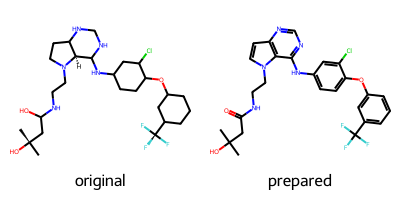

In [22]:
tutorial_smiles = "CC(C)(O)CC(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc(c4)C(F)(F)F)c(Cl)c3)c12"

tutorial_ligand = prepare_ligand(pdb_file, ligand_name, tutorial_smiles)

#rdkit_ligand = prepare_ligand(pdb_file, ligand_name, smiles)

[08:56:12] WARNING: More than one matching pattern found - picking one



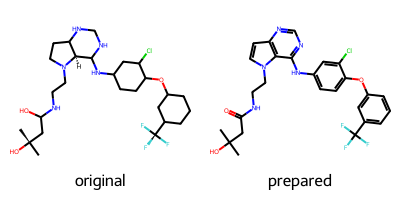

In [24]:
# https://www.rcsb.org/ligand/03P
# since the isometric SMILES from rcsb is not same with the one from the tutorial.
rcsb_smiles = "CC(C)(CC(=O)NCCn1ccc2c1c(ncn2)Nc3ccc(c(c3)Cl)Oc4cccc(c4)C(F)(F)F)O"
rcsb_ligand = prepare_ligand(pdb_file, ligand_name, rcsb_smiles)
# but 2D depiction is same.

### Merge protein and ligand
#### Conversion of the ligand to be compatible with MDTraj(openmm)
* For the ligand, we need to do several conversions, since it is currently an RDKit molecule.

#### Merge protein and ligand
* In the next step, we want to merge the prepared protein and ligand structures using the Python package MDTraj. MDTraj can handle the prepared protein, which is currently a PDBFixer molecule, a format that has a topology and atom positions similar to and usually interchangeable with OpenMM Modeller topologies and positions. 

In [25]:
def rdkit_to_openmm(rdkit_mol, name="LIG"):
    """
    Convert an RDKit molecule to an OpenMM molecule.
    Inspired by @hannahbrucemcdonald and @glass-w.

    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        RDKit molecule to convert.
    name: str
        Molecule name.

    Returns
    -------
    omm_molecule: openmm.app.Modeller
        OpenMM modeller object holding the molecule of interest.
    """
    # convert RDKit to OpenFF
    off_mol = Molecule.from_rdkit(rdkit_mol)

    # add name for molecule
    off_mol.name = name

    # add names for atoms
    element_counter_dict = {}
    for off_atom, rdkit_atom in zip(off_mol.atoms, rdkit_mol.GetAtoms()):
        element = rdkit_atom.GetSymbol()
        if element in element_counter_dict.keys():
            element_counter_dict[element] += 1
        else:
            element_counter_dict[element] = 1
        off_atom.name = element + str(element_counter_dict[element])

    # convert from OpenFF to OpenMM
    off_mol_topology = off_mol.to_topology()
    mol_topology = off_mol_topology.to_openmm()
    mol_positions = off_mol.conformers[0]

    # convert units from Ångström to nanometers
    # since OpenMM works in nm
    mol_positions = mol_positions.to("nanometers")

    # combine topology and positions in modeller object
    omm_mol = app.Modeller(mol_topology, mol_positions)

    return omm_mol

In [33]:
omm_ligand = rdkit_to_openmm(rcsb_ligand, ligand_name)

In [35]:
ligand_positions = omm_ligand.positions.in_units_of(unit.nanometers)

In [36]:
with open(result_dir / f"{ligand_name}_prepared.pdb", "w") as f:
    app.PDBFile.writeFile(omm_ligand.topology, ligand_positions, f)

In [42]:
ligand_path = str(result_dir / f"{ligand_name}_prepared.pdb")
ligand_view = nv.show_structure_file(ligand_path)
ligand_view.add_representation("ball+stick")
ligand_view.add_representation("unitcell")
ligand_view.camera = "orthographic"
ligand_view


NGLWidget()

In [43]:
# Merge protein and ligand with MDTraj
def merge_protein_and_ligand(protein, ligand):
    """
    Merge two OpenMM objects.

    Parameters
    ----------
    protein: pdbfixer.pdbfixer.PDBFixer
        Protein to merge.
    ligand: openmm.app.Modeller
        Ligand to merge.

    Returns
    -------
    complex_topology: openmm.app.topology.Topology
        The merged topology.
    complex_positions: openmm.unit.quantity.Quantity
        The merged positions.
    """
    # combine topologies
    md_protein_topology = md.Topology.from_openmm(protein.topology)  # using mdtraj for protein top
    md_ligand_topology = md.Topology.from_openmm(ligand.topology)  # using mdtraj for ligand top
    md_complex_topology = md_protein_topology.join(md_ligand_topology)  # add them together
    complex_topology = md_complex_topology.to_openmm()

    # combine positions
    total_atoms = len(protein.positions) + len(ligand.positions)

    # create an array for storing all atom positions as tupels containing a value and a unit
    # called OpenMM Quantities
    complex_positions = unit.Quantity(np.zeros([total_atoms, 3]), unit=unit.nanometers)
    complex_positions[: len(protein.positions)] = protein.positions  # add protein positions
    complex_positions[len(protein.positions) :] = ligand.positions  # add ligand positions

    return complex_topology, complex_positions

In [44]:
complex_topology, complex_positions = merge_protein_and_ligand(prepared_protein, omm_ligand)

/home/hyunsu/miniconda3/envs/openmm/lib/python3.10/site-packages/openmm/unit/quantity.py:753: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  self._value[key] = value / self.unit


In [45]:
print("Complex topology has", complex_topology.getNumAtoms(), "atoms.")
# NBVAL_CHECK_OUTPUT

Complex topology has 5561 atoms.


In [46]:
with open(result_dir / f"{pdbid}_{ligand_name}_complex.pdb", "w") as f:
    app.PDBFile.writeFile(complex_topology, complex_positions, f)

In [58]:
complex_path = str(result_dir / f"{pdbid}_{ligand_name}_complex.pdb")
complex_view = nv.show_structure_file(complex_path)
complex_view.add_representation("ball+stick", selection="not protein")
complex_view.add_representation("cartoon", selection="protein")
complex_view.add_representation("licorice", selection="water")
complex_view.add_representation("unitcell")
complex_view.camera = "orthographic"
complex_view

NGLWidget()